In [3]:
import tempfile
import subprocess, pathlib, shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [4]:
#exe="/scratch/spack-builds/atompaw-4.2.0.1/.spack-env/view/bin/atompaw"
exe="/home/simon/Software/atompaw-4.2.0.2/atompaw-4.2.0.2/src/atompaw"

In [5]:
element = 'La'
inputfile = """La  57
GGA-PBE  loggrid 2001 scalarrelativistic logderivrange -8 8 500
6 5 5 4 0
5 2 1
4 3 0
0 0 0
c
c
c
c
v
v
c
c
c
v
c
c
v
v
3
2.45 2.041 2.45 {rcore:.5f}                                             ! rpaw, rshape, rveff, rcore
n
y
2.0
n
y
2.0
n
y
2.0
n
VANDERBILT BESSELSHAPE
4 0.0
2.41
2.41
2.41
2.41
2.41
2.41
2.41
2.41
ABINITOUT
default
PWSCFOUT
UPFDX  0.0125d0  UPFXMIN  -7.d0  UPFZMESH  57.0
END
0"""

In [6]:
def run_atompaw(inputfile, rc_core):
    with tempfile.TemporaryDirectory() as tmpdirname:
        inputfile = inputfile.format(rcore=rc_core)
        procout = subprocess.run(exe, input=inputfile.encode(), 
                                 cwd=tmpdirname, shell=True, check=True, capture_output=True)
        outputs = list(pathlib.Path(tmpdirname).glob('*UPF'))
        #return procout
        if len(outputs) != 1:
            #return procout
            return {'upf': None, 'rc_core': rc_core, 'upf_generated': False, 'input': inputfile}        
        with open(outputs[0], 'r') as upf:
            return {'upf': upf.read(), 'rc_core': rc_core, 'upf_generated': True, 'input': inputfile}

In [7]:
def bisection_search(F, a, b, tol=1e-2, maxstep=10):
    # must have initial a,b such that F(a) -> good, F(b) -> bad
    x = (a+b)/2
    diff = b-a
    fx = F(x)
    i = 0
    fa = F(a)
    if not fa['upf_generated']:
        raise Exception('invalid starting guess F(a) must producing a UPF file')
    # last working value
    fl = fa
    
    while diff > tol:
        if fx['upf_generated']:
            # worked, try to increase r_core
            a = x
            fl = fx
        else:
            # failed
            b = x
        x = (a+b)/2
        diff = b-a
        print('* tol %.2g' % diff)
        print('\t trying rc_core=', x)
        fx = F(x)        
        i = i+1
        if i >= maxstep:
            raise Exception('bisection search failed.')
    return a, fl

In [8]:
r, res = bisection_search(lambda r: run_atompaw(inputfile, r), 1.6, 1.7, tol=1e-6, maxstep=30)

* tol 0.05
	 trying rc_core= 1.625
* tol 0.025
	 trying rc_core= 1.6125
* tol 0.012
	 trying rc_core= 1.6062500000000002
* tol 0.0062
	 trying rc_core= 1.609375
* tol 0.0031
	 trying rc_core= 1.6078125
* tol 0.0016
	 trying rc_core= 1.6070312500000001
* tol 0.00078
	 trying rc_core= 1.6066406250000003
* tol 0.00039
	 trying rc_core= 1.6068359375
* tol 0.0002
	 trying rc_core= 1.60693359375
* tol 9.8e-05
	 trying rc_core= 1.606884765625
* tol 4.9e-05
	 trying rc_core= 1.6069091796875
* tol 2.4e-05
	 trying rc_core= 1.60689697265625
* tol 1.2e-05
	 trying rc_core= 1.6068908691406252
* tol 6.1e-06
	 trying rc_core= 1.6068939208984376
* tol 3.1e-06
	 trying rc_core= 1.6068954467773438
* tol 1.5e-06
	 trying rc_core= 1.6068946838378908
* tol 7.6e-07
	 trying rc_core= 1.6068950653076173


In [9]:
with open('{:s}.upf'.format(element), 'w') as file:
    file.write(res['upf'])
with open('{:s}-atompaw.in'.format(element), 'w') as file:
    file.write(res['input'])

In [10]:
ll = [(x,run_atompaw(inputfile, rc_core=x)) for x in np.linspace(1., 2.5, 30)]

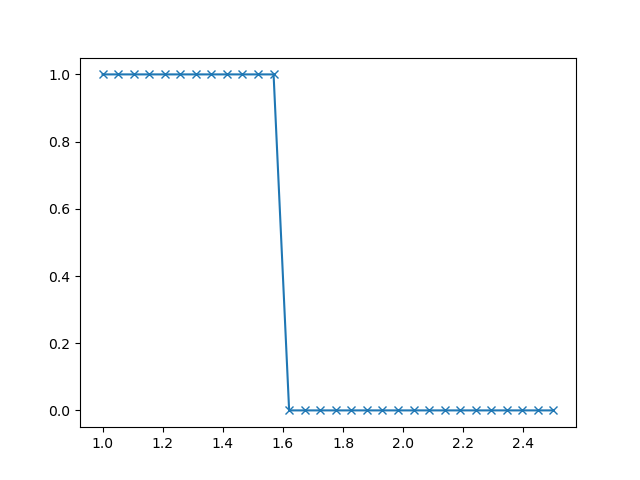

In [11]:
rs, good = zip(*[(r, res['upf_generated']) for r, res in ll])
plt.plot(rs, good, '-x')